#0. 프로젝트 사전준비

In [ ]:
#라이브러리 설치
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*
!pip install shap
!pip install xgboost
!pip install pdpbox

In [ ]:
#워닝 무시
%%capture

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')


In [ ]:
#한글폰트
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [ ]:
#폰트설정
import matplotlib.pyplot as plt

plt.rc('font', family='NanumBarunGothic') 

#1.데이터 선정 이유 및 문제 정의

 주 52시간 근무 확대, 워라벨이라는 신조어가 생기는 등 그 어느때 보다 개인의 휴식과 여가에 많은 관심이 쏟아지고 있습니다. 저는 그에따라서 각 개인의 여가활용과 연관되는 다양한 사회적 지표에 관심을 가지게 되었고. 개인이 향유하는 여가활동으로 그 사람의 사회 경제적 상태를 예측할 수 있는지 궁금했습니다.

 제 프로젝트는 그 중에서도 여가활동을 즐기는 여러가지 행태로 응답자의 소득수준을 측정할 수 있다 라는 가설을 세우고 모델을 머신러닝 모델을 통해서 그 가설을 검증해보려고 합니다.

 특히 제가 검증하고 싶은 부분은 소득수준이 높은 사람들은 그렇지 않은 사람들 보다 여가활동을 많이 즐길것이며 또한 소득에따른 여가활동의 차이가 있을것이다 라는 것입니다.

데이터는 마이크로 데이터에서 제공한 2018년 국민 여가활동 총 조사이며 약 만15세 이상 10,498명 시민에게 설문을 요청한 결과입니다.

(1) 데이터 불러오기

In [ ]:
#데이터 불러오기
import pandas as pd
import numpy as np
df = pd.read_csv('/content/drive/MyDrive/국민 여가활동 현황/총괄_2018_20210622_58396.csv', encoding = 'cp949')

#2.데이터를 이용한 가설 및 평가지표, 베이스라인 선택


(1)가설 : 여가활동 행태조사를 통해 경제적 상황 또는 수준을 구분할 수 있다.

(2)타겟설정
> 설문조사 내용중 개인의 소득수준을 12단계로 구분해 놓은 항목과 가구의 소득수준을 구분해 놓은 항목이 있었습니다. 

> 개인의 수입이 없는경우에도 가구의 소득수준이 높다면 여가활동을 즐기기에는 충분하다고 생각되기 때문에


> 개인의 소득수준 보다는 가구전체의 소득 수준을 보는것이 맞다고 생각했습니다.







In [ ]:
#타겟설정 
target = '문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구'

In [ ]:
#타겟 분포확인
'''
설문조사지를 참고하여 본 타깃의 내용
1.소득없음
2.월평균 100만원 미만
3.월평균 100만원 - 200만원 미만
4.월평균 200만원 - 300만원 미만
5.월평균 300만원 - 400만원 미만
6.월평균 400만원 - 500만원 미만
7.월평균 500만원 - 600만원 미만
8.월평균 600만원 - 700만원 미만
9.월평균 700만원 - 800만원 미만
10.월평균 800만원 - 900만원 미만
11.월평균 900만원 - 1,000만원 미만
12.월평균 1,000만원 이상
'''
df[target].value_counts()

5     2246
6     2214
4     1706
7     1405
3     1007
2      845
8      634
9      197
10      88
1       76
12      59
11      21
Name: 문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구, dtype: int64

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


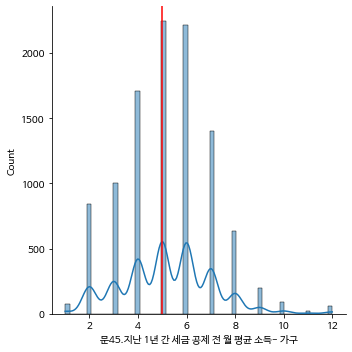

In [ ]:
#타겟의 분포 시각화
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(df[target],kde=True);
plt.axvline(5, color='red');

(3)기준모델 설정


> 타겟의 분포는 대체로 정규분포에 가까우며
> 12개 구간으로 나눈 소득수준 중 가장많은 구간인(최빈값) 5(월평균 300만원 - 400만원 미만)을 기준모델로 설정하였습니다.

> 또한 평가방법으로는 accuracy_score(정확도)를 사용하여 측정하였습니다.







In [ ]:
#기준모델 설정과 정확도 측정
major = df[target].mode()
y_pred = [major] * len(df[target])

In [ ]:
#기준모델의 정확도 측정
from sklearn.metrics import accuracy_score

print("baseline accuracy: ", accuracy_score(df[target], y_pred))

baseline accuracy:  0.21394551343112975


#3.EDA와 데이터 전처리

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10498 entries, 0 to 10497
Columns: 310 entries, 지역번호 to 장애여부
dtypes: float64(195), int64(115)
memory usage: 24.8 MB


In [ ]:
# 프로파일링을 먼저하여 대략적이 전처리 구상을 하겠습니다.
from pandas_profiling import ProfileReport

df.profile_report()

In [ ]:
#컬럼이 워낙 많아서 바로 프로파일링이 되지 않습니다.

In [ ]:
df.head()

,지역번호,문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 1. 전시회 관람,문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 2. 박물관 관람,"문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 3. 음악연주회관람(클래식, 오페라 등)","문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 4. 전통예술공연 관람(국악, 민속놀이 등)",문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 5. 연극공연 관람(뮤지컬 포함),문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 6. 무용공연 관람,문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 7. 영화관람,"문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 8. 연예공연 관람(쇼, 콘서트, 마술 쇼 등)",문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 9. 문학행사참여,문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 10. 글짓기/독서토론,"문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 11. 미술활동 (그림, 서예, 조각, 디자인, 도예, 만화 등)",문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 12. 악기연주/노래교실,"문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 13. 전통예술 배우기(사물놀이, 줄타기 등)",문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 14. 사진촬영(디지털카메라 포함),"문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 15. 춤/무용(발레, 한국무용, 현대무용 등)","문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 16. 스포츠 경기 직접관람- 경기장방문관람 (축구, 야구, 농구, 배구 등)","문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 17. 스포츠 경기 간접관람- TV, DMB를 통한관람(축구, 야구, 농구, 배구 등)",문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 18. 격투 스포츠 경기관람,문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 19. 온라인게임 경기 현장관람(e-스포츠경기포함),"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 20. 농구, 배구, 야구, 축구, 족구","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 21. 테니스, 스쿼시","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 22. 당구, 포켓볼","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 23. 볼링, 탁구",문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 24. 골프,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 25. 수영,"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 26. 윈드서핑, 수상스키, 스킨스쿠버다이빙, 래프팅, 요트","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 27. 스노보드, 스키 등","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 28. 아이스스케이트, 아이스하키 등",문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 29. 헬스(보디빌딩)/에어로빅,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 30. 요가/필라테스/태보,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 31. 배드민턴/줄넘기/맨손 스트레칭체조/훌라후프,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 32. 육상/조깅/속보,"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 33. 격투 스포츠(태권도, 유도, 합기도, 검도, 권투 등)","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 34. 댄스스포츠(탱고, 왈츠, 자이브, 맘보, 폴카, 차차차 등)",문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 35. 사이클링/산악자전거,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 36. 인라인스케이트,"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 37. 승마, 암벽등반, 철인삼종경기, 서바이벌","문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 38. 문화유적방문(고궁, 절, 유적지 등)",문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 39. 자연명승 및 풍경 관람,...,문36.만 나이,문37.전체 동거 가구원 수,문37.동거 자녀 현황 - 자녀없음,문37.동거 자녀 현황 - 미취학아동 자녀,문37.동거 자녀 현황 - 취학 자녀,문37.동거 자녀 현황 - 성인 자녀,문37.미취학아동 자녀 수,문37.취학 자녀 수,문37.성인 자녀 수,문38.가구주 여부,문38.응답자 성별,문38.가구주와의 관계,문38.가구주의 성별,문38.가구주의 학력 - 최종학력,문38.가구주의 학력 - 이수여부,문39.장애여부 및 장애등록여부,문39.장애유형,문39.장애등급,문40.지난 1주일 간 경제활동 여부,문40.경제활동 없는 경우 - 직업,문41.경제활동 한 경우 직업 - 주업,문41.경제활동 한 경우 직업 - 부업,문42.종사상의 지위,문43.주당 평균 근무 시간,문44.현재 근무지 주 5일제 시행 여부,문45.지난 1년 간 세금 공제 전 월 평균 소득- 본인,문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구,최종가중값,시도_2,권역,지역규모,성별,연령,학력,동거가구원수,혼인상태,가구주여부,종사상지위,가구소득,장애여부
0,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,60,1,1,NaN,NaN,NaN,NaN,NaN,NaN,1,2,NaN,2,4,1.0,1,NaN,NaN,1,NaN,9.0,98.0,1.0,36.0,1.0,3,3,4200.384228,11,1,1,2,6,3,1,3,1,1,2,3
1,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78,2,1,NaN,NaN,NaN,NaN,NaN,NaN,1,1,NaN,1,3,1.0,1,NaN,NaN,2,3.0,NaN,NaN,NaN,NaN,NaN,1,2,5885.444272,11,1,1,1,7,2,2,2,1,5,1,3
2,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,72,2,1,NaN,NaN,NaN,NaN,NaN,NaN,2,2,1.0,1,3,1.0,1,NaN,NaN,2,1.0,NaN,NaN,NaN,NaN,NaN,1,3,14696.664530,11,1,1,2,7,2,2,2,2,5,2,3
3,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,77,2,1,NaN,

In [ ]:
#컬럼수가 310가 됩니다 설문조사의 특성상 질문마다 컬럼이 형성되어있고 어떤 특성은 해당 질문에 대한 카테고리들이 모두 하나의 특성으로 되어있습니다.
  #모델의성능을 향상시키기 위해 필요한 컬럼들만 추출하여 피쳐 엔지니어링을 시행하겠습니다.

In [ ]:
#원본을 남겨두고 카피를 활용
df_1 = df.copy()

In [ ]:
#한번이라도 경험한 여가활동의 컬럼의 범위
df_1.columns[1:88].shape

(87,)

*   2번째 컬럼부터 88번 컬럼까지는 87개의 여가활동중 해본적이 있는것에는 해당 여가활동의 코드를 적고 그렇지 않은 항목은 결측값으로 내버려 두었습니다.

*   제가 구한데이터에서의 결측값은 모두 미해당 응답하지 않은것으로 확인되었으며 이는 앞으로 모두 0으로 채워놓겠습니다.


*   또한 87개의 여가활동은 크게 8가지 대분류로 나눠집니다.

*   여가활동의 8가지 대분류

     ['문화예술 관람','문화예술 체험', '스포츠 관람', '스포츠 참여', '관광활동', '취미 오락활동', '휴식활동', '사회및 기타활동']



















In [ ]:
#한번이라도 해본 여가활동을 모두 count 하기
leisure_name = df_1.columns[1:88]
leisure = df_1.copy()[leisure_name]

#각 각의 질문에 응답자들은 예 아니오로 대답을 했지만 1번문항의 예는 1 80번 문항의 예는 80 이런식으로 나와있다.
#각기 다른 카운트값을 모두 0 1 로 바꿔주기
def fix_value(df):
  for i in df.columns:
    df[i] = df[i].apply(lambda x: 1 if x > 0 else x)
  return df

fix_value(leisure)

#실제 데이터에서 87가지 여가활동을 8개 대분류로 구분하였다 각 대분류는 알파벳 a-h까지이다
#87가지 여가활동을 크게 8가지 로 분류 하겠음


,문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 1. 전시회 관람,문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 2. 박물관 관람,"문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 3. 음악연주회관람(클래식, 오페라 등)","문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 4. 전통예술공연 관람(국악, 민속놀이 등)",문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 5. 연극공연 관람(뮤지컬 포함),문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 6. 무용공연 관람,문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 7. 영화관람,"문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 8. 연예공연 관람(쇼, 콘서트, 마술 쇼 등)",문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 9. 문학행사참여,문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 10. 글짓기/독서토론,"문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 11. 미술활동 (그림, 서예, 조각, 디자인, 도예, 만화 등)",문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 12. 악기연주/노래교실,"문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 13. 전통예술 배우기(사물놀이, 줄타기 등)",문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 14. 사진촬영(디지털카메라 포함),"문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 15. 춤/무용(발레, 한국무용, 현대무용 등)","문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 16. 스포츠 경기 직접관람- 경기장방문관람 (축구, 야구, 농구, 배구 등)","문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 17. 스포츠 경기 간접관람- TV, DMB를 통한관람(축구, 야구, 농구, 배구 등)",문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 18. 격투 스포츠 경기관람,문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 19. 온라인게임 경기 현장관람(e-스포츠경기포함),"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 20. 농구, 배구, 야구, 축구, 족구","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 21. 테니스, 스쿼시","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 22. 당구, 포켓볼","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 23. 볼링, 탁구",문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 24. 골프,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 25. 수영,"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 26. 윈드서핑, 수상스키, 스킨스쿠버다이빙, 래프팅, 요트","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 27. 스노보드, 스키 등","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 28. 아이스스케이트, 아이스하키 등",문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 29. 헬스(보디빌딩)/에어로빅,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 30. 요가/필라테스/태보,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 31. 배드민턴/줄넘기/맨손 스트레칭체조/훌라후프,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 32. 육상/조깅/속보,"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 33. 격투 스포츠(태권도, 유도, 합기도, 검도, 권투 등)","문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 34. 댄스스포츠(탱고, 왈츠, 자이브, 맘보, 폴카, 차차차 등)",문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 35. 사이클링/산악자전거,문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 36. 인라인스케이트,"문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 37. 승마, 암벽등반, 철인삼종경기, 서바이벌","문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 38. 문화유적방문(고궁, 절, 유적지 등)",문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 39. 자연명승 및 풍경 관람,문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 40. 삼림욕,...,문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 48. 자동차 드라이브,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 49. 수집활동(스크랩 포함),"문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 50. 생활공예 (십자수, 비즈공예, D.I.Y, 꽃꽂이 등)",문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 51. 요리하기/다도,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 52. 애완동물 돌보기,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 53. 노래방가기,"문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 54. 인테리어(집, 자동차 등)",문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 55. 등산,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 56. 낚시,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 57. 미니홈피/블로그 관리,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 58. 인터넷 검색/채팅/UCC제작/SNS,"문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 59. 게임(인터넷, 닌텐도, PSP, PS3 등)",문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 60. 보드게임/퍼즐/큐브 맞추기,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 61. 바둑/장기/체스,"문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 62. 겜블(경마, 경륜, 카지노, 카드놀이, 고스톱, 마작 등)/복권구입",문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 63. 쇼핑/외식,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 64. 음주,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 65. 독서/만화책(웹툰) 보기,"문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 66. 미용(피부관리, 헤어관리, 네일아트, 마사지, 성형 등)",문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 67. 어학·기술·자격증취득공부·학원 등 이용,문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 68. 이색/테마카페 체험,"문1.한 번 이상 참여한 여가활동 - F. 취미오락활동(복수응답) - 69. 원예(화분, 화단가꾸기 등)",문1.한 번 이상 참여한 여가활동 - G. 휴식활동(복수응답) - 70. 산책 및 걷기,문1.한 번 이상 참여한 여가활동 - G. 휴식활동(복수응답) - 71. 목욕/사우나/찜질방,문1.한 번 이상 참여한 여가활동 - G. 휴식활동(복수응답) - 72. 낮잠,문1.한 번 이상 참여한 여가활동 - G. 휴식활동(복수응답) - 73. TV시청(DMB/IPTV 포함),문1.한 번 이상 참여한 여가활동 - G. 휴식활동(복수응답) - 74. 비디오/DVD/VOD 시청,문1.

In [ ]:
#각 대분류에는 알파벳구분이 되어있어 알파벳으로 해당 컬럼이름들을 찾아내려고함
for col in leisure.columns:
  if 'H' in col:
    print(col)

문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 79. 사회봉사활동
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 80. 종교활동
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 81. 클럽/나이트/디스코/캬바레 가기
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 82. 가족 및 친지방문
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 83. 잡담/통화하기/문자보내기
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 84. 계모임/동창회/사교(파티)모임
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 85. 이성교제(데이트)/미팅/소개팅
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 86. 친구만남/동호회 모임
문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 87. 위에서 분류되지 않은 기타 여가활동


In [ ]:
#찾아낸 알파벳 코드
A = ['문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 1. 전시회 관람',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 2. 박물관 관람',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 3. 음악연주회관람(클래식, 오페라 등)',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 4. 전통예술공연 관람(국악, 민속놀이 등)',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 5. 연극공연 관람(뮤지컬 포함)',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 6. 무용공연 관람',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 7. 영화관람',
         '문1.한 번 이상 참여한 여가활동 - A. 문화예술관람활동(복수응답) - 8. 연예공연 관람(쇼, 콘서트, 마술 쇼 등)'
         ]
B = ['문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 9. 문학행사참여',
         '문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 10. 글짓기/독서토론',
         '문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 11. 미술활동 (그림, 서예, 조각, 디자인, 도예, 만화 등)',
         '문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 12. 악기연주/노래교실',
         '문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 13. 전통예술 배우기(사물놀이, 줄타기 등)',
         '문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 14. 사진촬영(디지털카메라 포함)',
         '문1.한 번 이상 참여한 여가활동 - B. 문화예술참여활동(복수응답) - 15. 춤/무용(발레, 한국무용, 현대무용 등)'
         ]
C = ['문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 16. 스포츠 경기 직접관람- 경기장방문관람 (축구, 야구, 농구, 배구 등)',
     '문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 17. 스포츠 경기 간접관람- TV, DMB를 통한관람(축구, 야구, 농구, 배구 등)',
     '문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 18. 격투 스포츠 경기관람',
     '문1.한 번 이상 참여한 여가활동 - C. 스포츠관람활동(복수응답) - 19. 온라인게임 경기 현장관람(e-스포츠경기포함)'
     ]
D = ['문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 20. 농구, 배구, 야구, 축구, 족구',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 21. 테니스, 스쿼시',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 22. 당구, 포켓볼',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 23. 볼링, 탁구',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 24. 골프',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 25. 수영',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 26. 윈드서핑, 수상스키, 스킨스쿠버다이빙, 래프팅, 요트',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 27. 스노보드, 스키 등',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 28. 아이스스케이트, 아이스하키 등',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 29. 헬스(보디빌딩)/에어로빅',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 30. 요가/필라테스/태보',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 31. 배드민턴/줄넘기/맨손 스트레칭체조/훌라후프',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 32. 육상/조깅/속보',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 33. 격투 스포츠(태권도, 유도, 합기도, 검도, 권투 등)',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 34. 댄스스포츠(탱고, 왈츠, 자이브, 맘보, 폴카, 차차차 등)',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 35. 사이클링/산악자전거',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 36. 인라인스케이트',
     '문1.한 번 이상 참여한 여가활동 - D. 스포츠참여활동(복수응답) - 37. 승마, 암벽등반, 철인삼종경기, 서바이벌'
     ]
E = ['문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 38. 문화유적방문(고궁, 절, 유적지 등)',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 39. 자연명승 및 풍경 관람',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 40. 삼림욕',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 41. 국내캠핑',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 42. 해외여행',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 43. 소풍/야유회',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 44. 온천/해수욕',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 45. 유람선 타기',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 46. 테마파크가기/놀이공원/동물원/식물원 가기',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 47. 지역축제 참가',
     '문1.한 번 이상 참여한 여가활동 - E. 관광활동(복수응답) - 48. 자동차 드라이브'
     ]
F = ['문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 49. 수집활동(스크랩 포함)',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 50. 생활공예 (십자수, 비즈공예, D.I.Y, 꽃꽂이 등)',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 51. 요리하기/다도',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 52. 애완동물 돌보기',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 53. 노래방가기',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 54. 인테리어(집, 자동차 등)',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 55. 등산',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 56. 낚시',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 57. 미니홈피/블로그 관리',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 58. 인터넷 검색/채팅/UCC제작/SNS',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 59. 게임(인터넷, 닌텐도, PSP, PS3 등)',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 60. 보드게임/퍼즐/큐브 맞추기',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 61. 바둑/장기/체스',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 62. 겜블(경마, 경륜, 카지노, 카드놀이, 고스톱, 마작 등)/복권구입',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 63. 쇼핑/외식',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 64. 음주',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 65. 독서/만화책(웹툰) 보기',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 66. 미용(피부관리, 헤어관리, 네일아트, 마사지, 성형 등)',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 67. 어학·기술·자격증취득공부·학원 등 이용',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 68. 이색/테마카페 체험',
     '문1.한 번 이상 참여한 여가활동 -  F. 취미오락활동(복수응답) - 69. 원예(화분, 화단가꾸기 등)'
     ]
G = ['문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 70. 산책 및 걷기',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 71. 목욕/사우나/찜질방',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 72. 낮잠',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 73. TV시청(DMB/IPTV 포함)',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 74. 비디오/DVD/VOD 시청',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 75. 라디오/팟캐스트 청취',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 76. 음악감상',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 77. 신문/잡지보기',
     '문1.한 번 이상 참여한 여가활동 -  G. 휴식활동(복수응답) - 78. 아무것도 안 하기'
     ]
H = ['문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 79. 사회봉사활동',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 80. 종교활동',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 81. 클럽/나이트/디스코/캬바레 가기',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 82. 가족 및 친지방문',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 83. 잡담/통화하기/문자보내기',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 84. 계모임/동창회/사교(파티)모임',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 85. 이성교제(데이트)/미팅/소개팅',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 86. 친구만남/동호회 모임',
     '문1.한 번 이상 참여한 여가활동 - H.사회 및 기타 활동(복수응답) - 87. 위에서 분류되지 않은 기타 여가활동'
     ]

In [ ]:
#카운트 해주기
leisure['문화예술 관람'] = leisure[A].sum(axis =1)
leisure['문화예술 체험'] = leisure[B].sum(axis =1)
leisure['스포츠 관람'] = leisure[C].sum(axis =1)
leisure['스포츠 참여'] = leisure[D].sum(axis =1)
leisure['관광활동'] = leisure[E].sum(axis =1)
leisure['취미 오락활동'] = leisure[F].sum(axis =1)
leisure['휴식활동'] = leisure[G].sum(axis =1)
leisure['사회및 기타활동'] = leisure[H].sum(axis =1)

In [ ]:
#레져 경험에 대해서만 데이터프레임 생성
leisure_exp = leisure[['문화예술 관람','문화예술 체험', '스포츠 관람', '스포츠 참여', '관광활동', '취미 오락활동', '휴식활동', '사회및 기타활동']]

In [ ]:
#총 여가활동 경험 컬럼을 추가해주기
leisure_exp['총 여가활동 경험'] = leisure[['문화예술 관람','문화예술 체험', '스포츠 관람', '스포츠 참여', '관광활동', '취미 오락활동', '휴식활동', '사회및 기타활동']].sum(axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
leisure_exp

,문화예술 관람,문화예술 체험,스포츠 관람,스포츠 참여,관광활동,취미 오락활동,휴식활동,사회및 기타활동,총 여가활동 경험
0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,1.0,6.0
1,0.0,0.0,0.0,0.0,0.0,2.0,6.0,2.0,10.0
2,0.0,0.0,0.0,0.0,0.0,2.0,5.0,3.0,10.0
3,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,6.0
4,0.0,0.0,0.0,0.0,0.0,2.0,3.0,0.0,5.0
...,...,...,...,...,...,...,...,...,...
10493,5.0,1.0,1.0,0.0,4.0,9.0,7.0,4.0,31.0
10494,5.0,1.0,1.0,2.0,5.0,6.0,7.0,4.0,31.0
10495,6.0,0.0,1.0,0.0,7.0,4.0,4.0,3.0,25.0
10496,6.0,2.0,2.0,3.0,9.0,9.0,7.0,6.0,44.0


In [ ]:
#줄이고 남은 컬럼은 모두 지우겠습니다.
df_1.drop(A,axis=1,inplace=True)
df_1.drop(B,axis=1,inplace=True)
df_1.drop(C,axis=1,inplace=True)
df_1.drop(D,axis=1,inplace=True)
df_1.drop(E,axis=1,inplace=True)
df_1.drop(F,axis=1,inplace=True)
df_1.drop(G,axis=1,inplace=True)
df_1.drop(H,axis=1,inplace=True)

In [ ]:
#컬럼이 많아서 생략되는것을 방지하고 컬럼을더 확인해보겠습니다.
print("pandas version: ", pd.__version__)
pd.set_option('display.max_columns', 300)

pandas version:  1.1.5


In [ ]:
#필요없거나 중복되는 컬럼 지우기
df_1.drop(columns=['최종가중값','시도_2','가구소득','장애여부','성별','학력','동거가구원수','문37.미취학아동 자녀 수','문37.동거 자녀 현황 - 성인 자녀','문37.동거 자녀 현황 - 취학 자녀','문37.동거 자녀 현황 - 미취학아동 자녀',
                         '혼인상태','가구주여부','종사상지위','문39.장애유형','문39.장애등급','문37.동거 자녀 현황 - 자녀없음','문38.가구주와의 관계','문38.가구주의 성별','문38.가구주의 학력 - 최종학력','문38.가구주의 학력 - 이수여부',
                         '문40.지난 1주일 간 경제활동 여부','문40.경제활동 없는 경우 - 직업','문41.경제활동 한 경우 직업 - 주업','문41.경제활동 한 경우 직업 - 부업','문42.종사상의 지위','문38.가구주 여부','문37.성인 자녀 수',
                         '문37.취학 자녀 수','문34.본인의 교육정도 - 이수여부'],inplace=True)

In [ ]:
df_1.head()

,지역번호,문2.지난 1년간 가장 많이 참여한 여가활동 - 1순위,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 1회 여가 소요시간 - 시간,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 1회 여가 소요시간 - 분,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 1순위 여가활동 만족도,문2.지난 1년간 가장 많이 참여한 여가활동 - 2순위,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 여가 소요시간 - 시간,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 여가 소요시간 - 분,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 2순위 여가활동 만족도,문2.지난 1년간 가장 많이 참여한 여가활동 - 3순위,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 1회 여가 소요시간 - 시간,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 1회 여가 소요시간 - 분,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 3순위 여가활동 만족도,문2.지난 1년간 가장 많이 참여한 여가활동 - 4순위,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 여가 소요시간 - 시간,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 여가 소요시간 - 분,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 4순위 여가활동 만족도,문2.지난 1년간 가장 많이 참여한 여가활동 - 5순위,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 여가 소요시간 - 시간,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 여가 소요시간 - 분,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 5순위 여가활동 만족도,문3.여가활동 주 목적 - 복수응답 1,문4.가장 만족스런 여가활동 - 1순위,문4.가장 만족스런 여가활동 - 2순위,문4.가장 만족스런 여가활동 - 3순위,문5.여가경력- 반복참여 경험,문6.지속적으로 참여하는 여가활동 중 가장 많이하는 활동 - 코드,문6.지속적/반복적으로 참여하는 여가활동 상세유형 - 코드1,문6.지속적/반복적으로 참여하는 여가활동 상세유형 - 코드2,문6.지속적/반복적으로 참여하는 여가활동 상세유형 - 코드3,문7.지속적/반복적으로 참여하는 여가활동 - 참여기간(년),문7.지속적/반복적으로 참여하는 여가활동 - 참여기간(개월),문8.여가활동을 위한 별도의 지식.정보 습득여부,문9.지난 1년간 여가활동을 위한 월 평균 지출액(원),문9.지난 1년간 지출한 여가비의 충분도,문10.적절하다고 생각하는 여가비용(원)(월 평균),문11.평일에 참여한 여가활동 -A. 문화예술 관람 활동,문11.평일에 참여한 여가활동 만족도 -A. 문화예술 관람 활동,문11.평일에 희망하는 여가활동 -A. 문화예술 관람 활동,문11.평일에 참여한 여가활동 -B. 문화예술 참여 활동,문11.평일에 참여한 여가활동 만족도 -B. 문화예술 참여 활동,문11.평일에 희망하는 여가활동 -B. 문화예술 참여 활동,문11.평일에 참여한 여가활동 -C. 스포츠 관람 활동,문11.평일에 참여한 여가활동 만족도 -C. 스포츠 관람 활동,문11.평일에 희망하는 여가활동 -C. 스포츠 관람 활동,문11.평일에 참여한 여가활동 -D. 스포츠 참여 활동,문11.평일에 참여한 여가활동 만족도 -D. 스포츠 참여 활동,문11.평일에 희망하는 여가활동 -D. 스포츠 참여 활동,문11.평일에 참여한 여가활동 -E. 관광활동,문11.평일에 참여한 여가활동 만족도 -E. 관광활동,문11.평일에 희망하는 여가활동 -E. 관광활동,문11.평일에 참여한 여가활동 -F. 취미오락 활동,문11.평일에 참여한 여가활동 만족도 -F. 취미오락 활동,문11.평일에 희망하는 여가활동 -F. 취미오락 활동,문11.평일에 참여한 여가활동 -G. 휴식활동,문11.평일에 참여한 여가활동 만족도 -G. 휴식활동,문11.평일에 희망하는 여가활동 -G. 휴식활동,문11.평일에 참여한 여가활동 -H. 사회 및 기타 활동,문11.평일에 참여한 여가활동 만족도 -H. 사회 및 기타 활동,문11.평일에 희망하는 여가활동 -H. 사회 및 기타 활동,문12.휴일에 참여한 여가활동 -A. 문화예술 관람 활동,문12.휴일에 참여한 여가활동 만족도 -A. 문화예술 관람 활동,문12.휴일에 희망하는 여가활동 -A. 문화예술 관람 활동,문12.휴일에 참여한 여가활동 -B. 문화예술 참여 활동,문12.휴일에 참여한 여가활동 만족도 -B. 문화예술 참여 활동,문12.휴일에 희망하는 여가활동 -B. 문화예술 참여 활동,문12.휴일에 참여한 여가활동 -C. 스포츠 관람 활동,문12.휴일에 참여한 여가활동 만족도 -C. 스포츠 관람 활동,문12.휴일에 희망하는 여가활동 -C. 스포츠 관람 활동,문12.휴일에 참여한 여가활동 -D. 스포츠 참여 활동,문12.휴일에 참여한 여가활동 만족도 -D. 스포츠 참여 활동,문12.휴일에 희망하는 여가활동 -D. 스포츠 참여 활동,문12.휴일에 참여한 여가활동 -E. 관광활동,문12.휴일에 참여한 여가활동 만족도 -E. 관광활동,문12.휴일에 희망하는 여가활동 -E. 관광활동,문12.휴일에 참여한 여가활동 -F. 취미오락 활동,문12.휴일에 참여한 여가활동 만족도 -F. 취미오락 활동,문12.휴일에 희망하는 여가활동 -F. 취미오락 활동,문12.휴일에 참여한 여가활동 -G. 휴식활동,문12.휴일에 참여한 여가활동 만족도 -G. 휴식활동,문12.휴일에 희망하는 여가활동 -G. 휴식활동,문12.휴일에 참여한 여가활동 -H. 사회 및 기타 활동,문12.휴일에 참여한 여가활동 만족도 -H. 사회 및 기타 활동,문12.휴일에 희망하는 여가활동 -H. 사회 및 기타 활동,문13.지난 1년 간 하루 평균 여가시간 - 평일,문13.지난 1년 간 여가시간 충분도 - 평일,문13.지난 1년 간 여가시간 자유도 - 평일,문13.평균 여가 희망시간 - 평일,문13.지난 1년 간 하루 평균 여가시간 - 휴일,문13.지난 1년 간 여가시간 충분도 - 휴일,문13.지난 1년 간 여가시간 자유도 - 휴일,문13.평균 여가 희망시간 - 휴일,문14.지난 1년 간 휴가 사용 여부,문14.지난 1년 간 실제 사용 휴가 일수 - 전체,문14.지난 1년 간 실제 사용 휴가 분기 - 2017년 가을,문14.지난 1년 간 실제 사용 휴가 분기 - 2017년 겨울,문14.지난 1년 간 실제 사용 휴가 분기 - 2018년 봄,문14.지난 1년 간 실제 사용 휴가 분기 - 2018년 여름,문14.지난 1년 간 실제 사용 휴가 일수 - 2017년 가을,문14.지난 1년 간 실제 사용 휴가 일수 - 2017년 겨울,문14.지난 1년 간 실제 사용 휴가 일수 - 2018년 봄,문14.지난 1년 간 실제 사용 휴가 일수 - 2018년 여름,문14.휴가기간 중 여가활동 - 복수응답 1,문14.휴가기간 중 여가활동 - 복수응답 2,문14.휴가기간 중 여가활동 - 복수응답 3,문15.연휴기간 중 여가활동 - 복수응답 1,문15.연휴기간 중 여가활동 - 복수응답 2,문15.연휴기간 중 여가활동 - 복수응답 3,문16.집 외 가장 많이 이용한 여가공간 - 1순위,문16.집 외 가장 많이 이용한 여가공간 - 2순위,문16.집 외 가장 많이 이용한 여가공간 - 3순위

In [ ]:
df_1.shape

(10498, 193)

In [ ]:
#지난 1년간의 여가활동 조사
cols = [] 
for word in df_1.columns: 
  if '문2.' in word:
    cols.append(word)

In [ ]:
leisure_last1y = df_1[cols]



*   빈도와 시간 분은 비슷한 의미를 내포하고있음으로 빈도만 남겨두고 제거하겠습니다.(회당 비용이 컬럼이 있기때문에)


In [ ]:
#시간과 분을 합쳐서 한 컬럼으로 만들어주기
cols2 = [] 
for word in leisure_last1y.columns: 
  if '시간' in word:
    cols2.append(word)

In [ ]:
leisure_last1y.drop(columns= cols2, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,




*   가장 만족스런 여가활동이란 컬럼이 존재함으로 만족도 또한 제거하겠습니다.




In [ ]:
cols3 = [] 
for word in leisure_last1y.columns: 
  if '만족도' in word:
    cols3.append(word)

In [ ]:
leisure_last1y.drop(columns= cols3, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
leisure_last1y

,문2.지난 1년간 가장 많이 참여한 여가활동 - 1순위,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 1순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 여가활동 - 2순위,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 여가활동 - 3순위,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 3순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 여가활동 - 4순위,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원),문2.지난 1년간 가장 많이 참여한 여가활동 - 5순위,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 동반자,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 빈도,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원)
0,73,1,1,0,71,1,2,15000,72,1,2,0,83,4,2,0,70.0,2.0,3.0,0.0
1,73,1,1,1000,77,1,1,500,70,1,2,2000,72,1,2,0,64.0,3.0,4.0,20000.0
2,70,1,1,0,73,1,1,1000,82,2,3,2000,63,3,4,50000,66.0,1.0,4.0,30000.0
3,70,1,1,0,73,2,1,100,80,2,2,10000,64,3,3,50000,63.0,2.0,4.0,50000.0
4,73,1,1,100,72,1,1,0,64,3,2,10000,70,1,2,0,61.0,3.0,3.0,1000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10493,73,1,1,1000,76,1,1,500,57,1,1,1000,58,5,2,1000,63.0,1.0,2.0,30000.0
10494,25,1,2,3000,65,1,2,500,77,1,2,500,55,2,3,10000,86.0,3.0,3.0,10000.0
10495,55,1,2,2000,67,1,2,5000,71,1,2,3000,42,1,5,80000,1.0,2.0,5.0,10000.0
10496,24,5,2,100000,67,1,2,1000,30,1,2,0,83,1,2,1300,65.0,1.0,2.0,800.0


In [ ]:
# 평일 여가활동 검색
cols4 = [] 
for word in df_1.columns: 
  if '문11.' in word:
    cols4.append(word)

In [ ]:
leisure_wd = df_1[cols4]

In [ ]:
cols5 = [] 
for word in leisure_wd.columns: 
  if '희망' in word:
    cols5.append(word)

cols6 = [] 
for word in leisure_wd.columns: 
  if '만족도' in word:
    cols6.append(word)

In [ ]:
leisure_wd.drop(columns=cols5,inplace=True)
leisure_wd.drop(columns=cols6,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#휴일 여가활동 검색
cols7 = [] 
for word in df_1.columns: 
  if '문12.' in word:
    cols7.append(word)

leisure_we = df_1[cols7]

In [ ]:
cols8 = [] 
for word in leisure_we.columns: 
  if '희망' in word:
    cols8.append(word)

cols9 = [] 
for word in leisure_we.columns: 
  if '만족도' in word:
    cols9.append(word)

In [ ]:
leisure_we.drop(columns=cols8,inplace=True)
leisure_we.drop(columns=cols9,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
#여가활동 만족도 조사
cols10 = [] 
for word in df_1.columns: 
  if '문4.' in word:
    cols10.append(word)

leisure_stf = df_1[cols10]

In [ ]:
leisure_stf

,문4.가장 만족스런 여가활동 - 1순위,문4.가장 만족스런 여가활동 - 2순위,문4.가장 만족스런 여가활동 - 3순위
0,72,71.0,78.0
1,86,70.0,77.0
2,70,66.0,63.0
3,70,73.0,64.0
4,73,72.0,64.0
...,...,...,...
10493,86,57.0,54.0
10494,25,55.0,86.0
10495,42,55.0,71.0
10496,24,67.0,65.0


In [ ]:
cols11 = [] 
for word in df_1.columns: 
  if '문6.' in word:
    cols11.append(word)

leisure_frq = df_1[cols11]

In [ ]:
#응답자 개인의 정보

In [ ]:
indvidual_info = df_1.columns[175:198]

In [ ]:
indvidual_info = df_1[indvidual_info]

In [ ]:
#불필요한 컬럼 제거
indvidual_info.drop(columns=['문30.전반적 여가생활 불만족 이유','문31.여가인식 - 여가활동이 삶의 필수적인 요건이다',	'문32.여가인식 - 여가활동이 삶의 긍정적 영향을 끼치는 지 여부',
                             '문45.지난 1년 간 세금 공제 전 월 평균 소득- 본인',	'문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구','권역','연령'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
indvidual_info

,문30.전반적 여가생활 만족도,문33.현재 행복 수준 - 10점 척도,문34.본인의 교육정도 - 최종학력,문35.혼인상태,문36.만 나이,문37.전체 동거 가구원 수,문38.응답자 성별,문39.장애여부 및 장애등록여부,문43.주당 평균 근무 시간,문44.현재 근무지 주 5일제 시행 여부,지역규모
0,2,6,4,3,60,1,2,1,36.0,1.0,1
1,3,5,3,2,78,2,1,1,NaN,NaN,1
2,5,6,3,2,72,2,2,1,NaN,NaN,1
3,6,9,2,2,77,2,1,1,NaN,NaN,1
4,6,5,1,3,75,1,1,1,15.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...
10493,4,9,6,2,40,2,2,1,55.0,2.0,2
10494,7,10,6,2,51,2,2,1,25.0,1.0,2
10495,7,10,7,2,61,2,2,1,NaN,NaN,2
10496,5,8,5,2,57,3,2,1,40.0,2.0,2


In [ ]:
#선택하거나 가공한 특성들과 타겟을 취합하여 새로운 데이터 프레임 생성하기

df_2 = pd.concat([leisure_exp,leisure_last1y,leisure_stf,leisure_wd,leisure_we,leisure_frq,indvidual_info],axis=1)

In [ ]:
df_3 = pd.concat([leisure_exp,leisure_last1y,leisure_stf,leisure_wd,leisure_we,leisure_frq],axis=1)
#무응답인 결측값은 0으로 채우겠습니다.
df_3.fillna(0,inplace=True)

In [ ]:
#무응답인 결측값은 0으로 채우겠습니다.
df_2.fillna(0,inplace=True)

In [ ]:
#전체 가구원 수 제거
df_2.drop(columns='문37.전체 동거 가구원 수',inplace=True)

* Data Leakage가 있었나요? 없었다면 어떻게 방지했나요?


> 타겟 (가구소득수준) 과 연관성이 큰 개인소득이라는 특성이 있었습니다. 개인소득이 높다면 당연히 가구소득수준 또한 높을 것임으로 해당특성은 모델을 만드는 데이터셋에서 제외하였습니다.

> 또한 가구원 수가 많다면 가구의 소득이 높을 수 밖에 없기 때문에 동거가구원 특성도 제거했습니다.










#4.머신러닝 방식 적용 및 교차검증




> 위의 설문데이터에서 추출해낸 여가활동 데이터를 가지고 몇가지 모델링을 해보려합니다.





1.   훈련 테스트로 데이터 스플릿하기



In [ ]:
#교차검증을 수행할것이기 때문에 val 은 생성하지 않았습니다.

In [ ]:
#타겟 카디널리티를 줄이는 함수
def fix_target_val(df, target):
    for i in df.index:
        val = df.loc[i, col]
        if val in [1,2,3,4] :
          df.loc[i, col] = 1
        elif val in [5,6,7,8] :
          df.loc[i, col] = 2
        elif val  > 8 :
          df.loc[i, col] = 3
    df = df[col]
    return df

In [ ]:
fix_target_val(df_1,'문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구')

0        1
1        1
2        1
3        1
4        1
        ..
10493    2
10494    2
10495    3
10496    3
10497    2
Name: 문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구, Length: 10498, dtype: int64

In [ ]:
target_2 = df_1[[target]]

In [ ]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(df_3, df[target], stratify = df[target] ,test_size=0.2, random_state=2)
#stratify = df[target] 타깃의 분포를 유지하겠다.

X_train2, X_test2, y_train2, y_test2 = train_test_split(df_3, target_2[target], stratify = target_2[target] ,test_size=0.2, random_state=2)


In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8398, 52), (2100, 52), (8398,), (2100,))

In [ ]:
X_train2.shape, X_test2.shape, y_train2.shape, y_test2.shape

((8398, 52), (2100, 52), (8398,), (2100,))



2.   랜덤포레스트 분류기



In [ ]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline

#이미 인코딩이 되어있는 데이터이고 결측값이 없기때문에 모델로만 돌려보겠습니다.

#타깃 카디널리티 12일때
forest = RandomForestClassifier(max_depth=12 ,n_jobs=-1,random_state=2)

forest.fit(X_train,y_train)

print('타깃 카디널리티 12일 경우 훈련 정확도: ', forest.score(X_train, y_train))

#교차 검증
from sklearn.model_selection import cross_val_score
#warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')
k = 5
scores = cross_val_score(forest, X_train, y_train, cv=k, 
                         scoring='accuracy') #scoring='accuracy' 분류모델이기 때문에.


print(f'타깃 카디널리티 12일 경우 검증정확도 ({k} folds):', scores)
print(f'타깃 카디널리티 12일 경우 검증정확도 평균 ({k} folds):', scores.mean())

타깃 카디널리티 12일 경우 훈련 정확도:  0.9124791617051679
타깃 카디널리티 12일 경우 검증정확도 (5 folds): [0.2672619  0.28392857 0.26428571 0.27099464 0.27754616]
타깃 카디널리티 12일 경우 검증정확도 평균 (5 folds): 0.2728033977140588


In [ ]:
#타깃 카디널리티 3일때
#이미 인코딩이 되어있는 데이터이고 결측값이 없기때문에 모델로만 돌려보겠습니다.

forest = RandomForestClassifier(max_depth=12 ,n_jobs=-1,random_state=2)

forest.fit(X_train2,y_train2)

print('타깃 카디널리티 3일 경우 훈련 정확도: ', forest.score(X_train2, y_train2))

#교차 검증
from sklearn.model_selection import cross_val_score
#warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')
k = 5
scores = cross_val_score(forest, X_train2, y_train2, cv=k, 
                         scoring='accuracy') #scoring='accuracy' 분류모델이기 때문에.


print(f'타깃 카디널리티 3일 경우 검증정확도 ({k} folds):', scores)
print(f'타깃 카디널리티 3일 경우 검증정확도 평균 ({k} folds):', scores.mean())

타깃 카디널리티 3일 경우 훈련 정확도:  0.8711597999523696
타깃 카디널리티 3일 경우 검증정확도 (5 folds): [0.69404762 0.71666667 0.71488095 0.71411554 0.69088743]
타깃 카디널리티 3일 경우 검증정확도 평균 (5 folds): 0.7061196432116622


In [ ]:
#엄청나게 과적합이 일어났습니다.
  #아마도 데이터가 부족한데 타깃의 종류가 12개나 되어서 그런것 같습니다.
  #타겟클래스가 12개일때는
타깃 카디널리티 12일 경우 훈련 정확도:  0.8904501071683735
타깃 카디널리티 12일 경우 검증정확도 (5 folds): [0.35059524 0.36369048 0.36130952 0.35973794 0.37343657]
타깃 카디널리티 12일 경우 검증정확도 평균 (5 folds): 0.36175394934626615
#타깃의 카디널리티를 줄인다면 어떻게 되는지 확인해보겠습니다.
  #타겟 클래스를 3개로 줄였을때 
    #1 = [1,2,3,4], 2 = [5,6,7,8], 3=[9,10,11,12]
타깃 카디널리티 3일 경우 훈련 정확도:  0.8656823053107883
타깃 카디널리티 3일 경우 검증정확도 (5 folds): [0.75119048 0.76845238 0.7827381  0.77903514 0.76057177]
타깃 카디널리티 3일 경우 검증정확도 평균 (5 folds): 0.7683975722510565



3.   XGboost 분류기



In [ ]:
from xgboost import XGBClassifier
from xgboost import cv
import xgboost as xgb
#타겟 카디널리티 12일 경우

xgbc = xgb.XGBClassifier(
    n_estimators=500,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=3,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
#     scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1,
    random_state=2
)

eval_set = [(X_train, y_train)]

xgbc.fit(X_train, y_train, 
         eval_set=eval_set, 
         eval_metric='merror', #멀티클래스 분류이기 때문에 'merror'
         early_stopping_rounds =50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

print('타겟 카디널리티 12일 경우 훈련 정확도: ', xgbc.score(X_train, y_train))

#교차 검증
from sklearn.model_selection import cross_val_score
#warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')
k = 3
scores = cross_val_score(xgbc, X_train, y_train, cv=k, 
                         scoring='accuracy') #scoring='accuracy' 분류모델이기 때문에.

print(f'타겟 카디널리티 12일 경우 검증정확도 ({k} folds):', scores)
print(f'타겟 카디널리티 12일 경우 검증정확도 평균 ({k} folds):', scores.mean())
#warning 제거를 위한 코드

[0]	validation_0-merror:0.731484
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.715647
[2]	validation_0-merror:0.709097
[3]	validation_0-merror:0.705287
[4]	validation_0-merror:0.701477
[5]	validation_0-merror:0.695523
[6]	validation_0-merror:0.689688
[7]	validation_0-merror:0.688378
[8]	validation_0-merror:0.683258
[9]	validation_0-merror:0.678376
[10]	validation_0-merror:0.675518
[11]	validation_0-merror:0.67528
[12]	validation_0-merror:0.67135
[13]	validation_0-merror:0.666945
[14]	validation_0-merror:0.664087
[15]	validation_0-merror:0.659443
[16]	validation_0-merror:0.655156
[17]	validation_0-merror:0.654442
[18]	validation_0-merror:0.652179
[19]	validation_0-merror:0.650274
[20]	validation_0-merror:0.647416
[21]	validation_0-merror:0.643963
[22]	validation_0-merror:0.642772
[23]	validation_0-merror:0.637414
[24]	validation_0-merror:0.635151
[25]	validation_0-merror:0.63146
[26]	validation_0-merror:0.627411
[27]	validation_0-merror:0.6

In [ ]:
#타겟 카디널리티 3일 경우

xgbc = xgb.XGBClassifier(
    n_estimators=500,  # <= 1000 트리로 설정했지만, early stopping 에 따라 조절됩니다.
    max_depth=3,        # default=3, high cardinality 특성을 위해 기본보다 높여 보았습니다.
    learning_rate=0.2,
#     scale_pos_weight=ratio, # imbalance 데이터 일 경우 비율을 적용합니다.
    n_jobs=-1,
    random_state=2
)

eval_set = [(X_train2, y_train2)]

xgbc.fit(X_train2, y_train2, 
         eval_set=eval_set, 
         eval_metric='merror', #멀티클래스 분류이기 때문에 'merror'
         early_stopping_rounds =50) # 50 rounds 동안 스코어의 개선이 없으면 멈춤

print('타겟 카디널리티 3일 경우 훈련 정확도: ', xgbc.score(X_train2, y_train2))

#교차 검증
from sklearn.model_selection import cross_val_score
#warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')
k = 3
scores = cross_val_score(xgbc, X_train2, y_train2, cv=k, 
                         scoring='accuracy') #scoring='accuracy' 분류모델이기 때문에.

print(f'타겟 카디널리티 3일 경우 검증정확도 ({k} folds):', scores)
print(f'타겟 카디널리티 3일 경우 검증정확도 평균 ({k} folds):', scores.mean())
#warning 제거를 위한 코드

[0]	validation_0-merror:0.311503
Will train until validation_0-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.314122
[2]	validation_0-merror:0.306502
[3]	validation_0-merror:0.304239
[4]	validation_0-merror:0.299238
[5]	validation_0-merror:0.299119
[6]	validation_0-merror:0.29769
[7]	validation_0-merror:0.29388
[8]	validation_0-merror:0.293522
[9]	validation_0-merror:0.290188
[10]	validation_0-merror:0.287449
[11]	validation_0-merror:0.287449
[12]	validation_0-merror:0.286616
[13]	validation_0-merror:0.285187
[14]	validation_0-merror:0.285068
[15]	validation_0-merror:0.284234
[16]	validation_0-merror:0.281377
[17]	validation_0-merror:0.279709
[18]	validation_0-merror:0.279471
[19]	validation_0-merror:0.278042
[20]	validation_0-merror:0.276494
[21]	validation_0-merror:0.274946
[22]	validation_0-merror:0.273398
[23]	validation_0-merror:0.273041
[24]	validation_0-merror:0.271612
[25]	validation_0-merror:0.27197
[26]	validation_0-merror:0.271255
[27]	validation_0-merror:0.2

In [ ]:
#타겟이 12종류일 때

타겟 카디널리티 12일 경우 훈련 정확도:  0.9752321981424149
타겟 카디널리티 12일 경우 검증정확도 (3 folds): [0.33857143 0.32976063 0.33404787]
타겟 카디널리티 12일 경우 검증정확도 평균 (3 folds): 0.3341266438694091

#타겟을 3종으로 줄였을때

타겟 카디널리티 3일 경우 훈련 정확도:  0.9784472493450822
타겟 카디널리티 3일 경우 검증정확도 (3 folds): [0.75       0.75848517 0.75955698]
타겟 카디널리티 3일 경우 검증정확도 평균 (3 folds): 0.7560140526378469

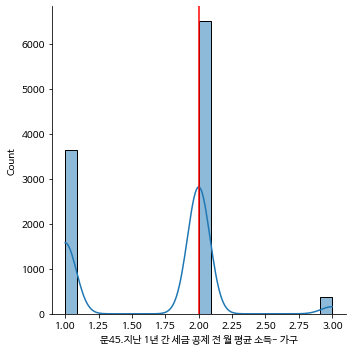

In [ ]:
#타겟카디널리티를 3개로 줄였을때의 기준모델 확인
sns.displot(target_2[target],kde=True);
plt.axvline(2, color='red');

In [ ]:
#3개의 카디널리티로 줄인 기준모델의 정확도
major = target_2[target].mode()
y_pred = [major] * len(target_2[target])

print("baseline accuracy: ", accuracy_score(target_2[target], y_pred))

baseline accuracy:  0.6190702991045913


* 더 높은 성능을 내기 위해 파라미터 튜닝을 해보겠습니다.

In [ ]:
#랜덤포레스트에 적용
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
dists = {
    'n_estimators': [50,100,150,200,250], 
    'max_depth': randint(10, 16), 
    'max_features': uniform(0, 1),
    'min_samples_leaf': randint(1,4)
    }


clf = RandomizedSearchCV(
    forest, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

#타깃 카디널리티 3일경우
clf.fit(X_train2, y_train2);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  8.6min finished


In [ ]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('accuracy: ', clf.best_score_)

최적 하이퍼파라미터:  {'max_depth': 14, 'max_features': 0.5899327480161658, 'min_samples_leaf': 1, 'n_estimators': 250}
accuracy:  0.7145754436108134


In [ ]:
forest = clf.best_estimator_

In [ ]:
#검증해보기
k = 5
scores = cross_val_score(forest, X_train2, y_train2, cv=k, 
                         scoring='accuracy') #scoring='accuracy' 분류모델이기 때문에.

print('타깃 카디널리티 3일 경우 훈련 정확도: ', forest.score(X_train2, y_train2))
print(f'타깃 카디널리티 3일 경우 검증정확도 ({k} folds):', scores)
print(f'타깃 카디널리티 3일 경우 검증정확도 평균 ({k} folds):', scores.mean())

타깃 카디널리티 3일 경우 훈련 정확도:  0.9404620147654204
타깃 카디널리티 3일 경우 검증정확도 (5 folds): [0.70357143 0.72440476 0.71785714 0.72424062 0.70577725]
타깃 카디널리티 3일 경우 검증정확도 평균 (5 folds): 0.7151702402223545


* 테스트 데이터 점수

In [ ]:
#랜덤포레스트 테스트 결과

y_pred = forest.predict(X_test2)
print('타깃 카디널리티 3일 경우 test 정확도: ', accuracy_score(y_pred, y_test2))
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred))

타깃 카디널리티 3일 경우 test 정확도:  0.710952380952381
              precision    recall  f1-score   support

           1       0.73      0.41      0.53       727
           2       0.71      0.92      0.80      1300
           3       0.00      0.00      0.00        73

    accuracy                           0.71      2100
   macro avg       0.48      0.44      0.44      2100
weighted avg       0.69      0.71      0.68      2100



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#XGboost 테스트 결과

y_pred = xgbc.predict(X_test2)
print('타깃 카디널리티 3일 경우 test 정확도: ', accuracy_score(y_pred, y_test2))
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred))

타깃 카디널리티 3일 경우 test 정확도:  0.7080952380952381
              precision    recall  f1-score   support

           1       0.67      0.48      0.56       727
           2       0.72      0.87      0.79      1300
           3       0.14      0.01      0.03        73

    accuracy                           0.71      2100
   macro avg       0.51      0.46      0.46      2100
weighted avg       0.69      0.71      0.69      2100



* 서범석님이 만들고자 하는 모델은 언제 유용한가요? 어떤 한계를 가지고 있나요?

In [ ]:
#위의 두 모델 모두 타겟이 12종일 때 와 3종으로 줄였을때 상당한 성능 차이를 보였다.
  #타겟이 12종의 카디널리티를 지녔을때는 과적합 또는 과소적합이 상당히 심했는데
  #카디널리티를 3으로 줄이고 나니 76-77%수준의 정확도를 보여줬다.
  #개인정보를 제거하고 나서는 71% 정도 수준의 정확도를보였다
  #타깃의 카디널리티가 높다면 그만큼 학습에 많은 자료가 필요하기 때문이라고 생각된다.

#하지만 어떤 종류의 타겟으로 하던 모든 모델이 기준모델보다 높은 성능을 보였다.

#5.머신러닝 모델 해석



> 모델이 어떤 과정을 거쳐서 예측을 하는지 보여드리겠습니다.



In [ ]:
!pip install graphviz

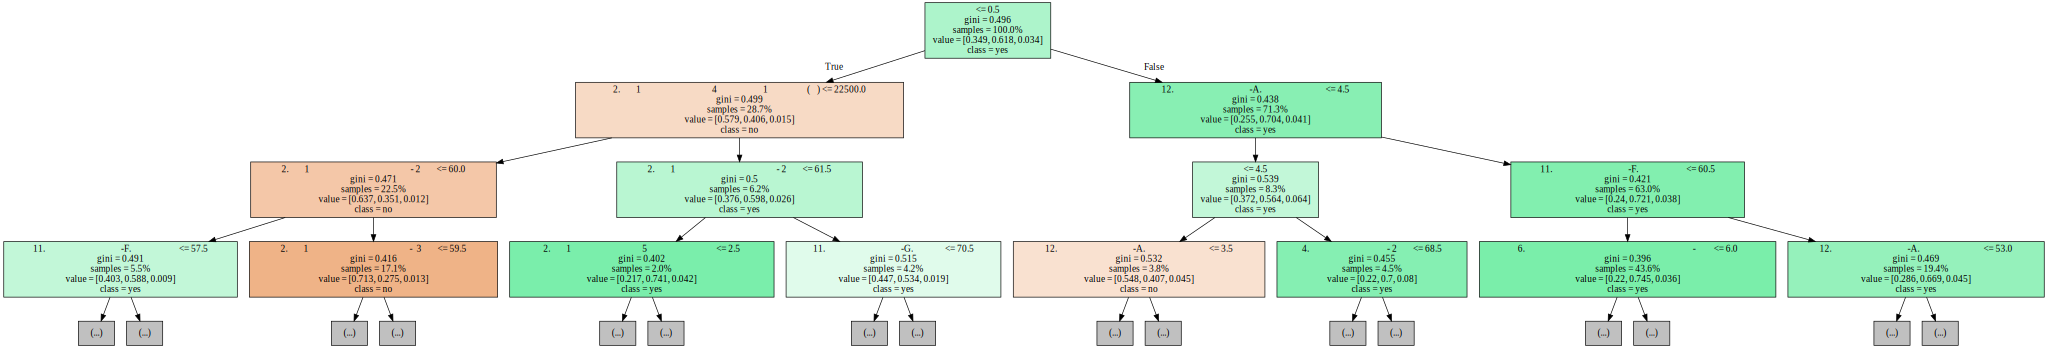

In [ ]:
#랜덤포레스트 그래프 구현
# graphviz 설치방법: conda install -c conda-forge python-graphviz
import graphviz
from sklearn.tree import export_graphviz
from xgboost import plot_tree


estimator = forest.estimators_[3]

dot_data = export_graphviz(estimator
                          , max_depth=3
                          , feature_names=X_test2.columns
                          , class_names=['no', 'yes']
                          , filled=True
                          , proportion=True)


display(graphviz.Source(dot_data))



> 각각의 모델이 어떤 특성을 중요하게 사용했는지 확인해보겠습니다.



In [ ]:
! pip install eli5

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    forest, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_train2, y_train2);

In [ ]:
feature_names = X_train2.columns.tolist()

In [ ]:
#개인정보 포함
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names) # list 형식으로 넣어야 합니다

Weight,Feature
0.1624 ± 0.0048,문36.만 나이
0.1064 ± 0.0033,문35.혼인상태
0.0591 ± 0.0057,문34.본인의 교육정도 - 최종학력
0.0215 ± 0.0028,문43.주당 평균 근무 시간
0.0103 ± 0.0013,문4.가장 만족스런 여가활동 - 1순위
0.0098 ± 0.0013,문30.전반적 여가생활 만족도
0.0095 ± 0.0006,문2.지난 1년간 가장 많이 참여한 여가활동 - 5순위
0.0093 ± 0.0012,문4.가장 만족스런 여가활동 - 3순위
0.0092 ± 0.0014,문4.가장 만족스런 여가활동 - 2순위
0.0081 ± 0.0019,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원)


In [ ]:
#개인정보 미포함
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names) # list 형식으로 넣어야 합니다

Weight,Feature
0.0554 ± 0.0039,문2.지난 1년간 가장 많이 참여한 여가활동 - 2순위
0.0418 ± 0.0008,문12.휴일에 참여한 여가활동 -A. 문화예술 관람 활동
0.0397 ± 0.0008,문화예술 관람
0.0387 ± 0.0004,문2.지난 1년간 가장 많이 참여한 여가활동 - 5순위
0.0299 ± 0.0010,취미 오락활동
0.0286 ± 0.0017,문2.지난 1년간 가장 많이 참여한 여가활동 - 3순위
0.0281 ± 0.0027,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원)
0.0275 ± 0.0018,문4.가장 만족스런 여가활동 - 1순위
0.0271 ± 0.0013,관광활동
0.0257 ± 0.0013,문4.가장 만족스런 여가활동 - 2순위


In [ ]:
forest_imp = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)[0:10]

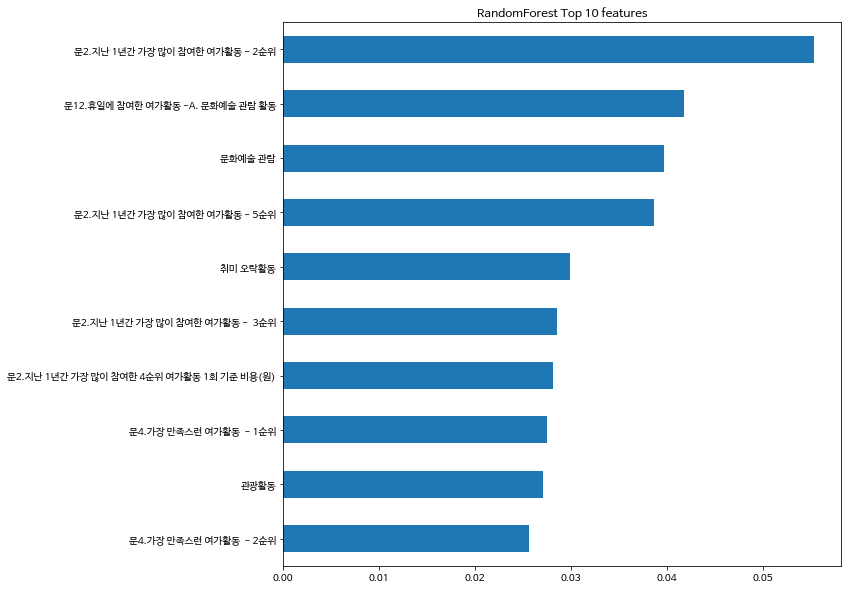

In [ ]:
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'RandomForest Top 10 features')
forest_imp.sort_values().plot.barh();

In [ ]:
#xgboost
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import eli5
from eli5.sklearn import PermutationImportance

# permuter 정의
permuter = PermutationImportance(
    xgbc, # model
    scoring='accuracy', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

# permuter 계산은 preprocessing 된 X_val을 사용합니다.

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업입니다
permuter.fit(X_train2, y_train2);

In [ ]:
# 개인정보 포함
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names) # list 형식으로 넣어야 합니다

Weight,Feature
0.1256 ± 0.0041,문36.만 나이
0.0814 ± 0.0079,문35.혼인상태
0.0379 ± 0.0008,문34.본인의 교육정도 - 최종학력
0.0262 ± 0.0037,문43.주당 평균 근무 시간
0.0189 ± 0.0025,문4.가장 만족스런 여가활동 - 1순위
0.0176 ± 0.0022,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원)
0.0168 ± 0.0014,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 기준 비용(원)
0.0165 ± 0.0017,문4.가장 만족스런 여가활동 - 2순위
0.0139 ± 0.0010,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원)
0.0133 ± 0.0014,문4.가장 만족스런 여가활동 - 3순위


In [ ]:
#개인정보 미포함
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names) # list 형식으로 넣어야 합니다

Weight,Feature
0.0224 ± 0.0035,문11.평일에 참여한 여가활동 -F. 취미오락 활동
0.0206 ± 0.0024,문4.가장 만족스런 여가활동 - 1순위
0.0206 ± 0.0051,문2.지난 1년간 가장 많이 참여한 여가활동 - 2순위
0.0197 ± 0.0030,문2.지난 1년간 가장 많이 참여한 여가활동 - 3순위
0.0187 ± 0.0017,문4.가장 만족스런 여가활동 - 3순위
0.0187 ± 0.0042,문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원)
0.0186 ± 0.0022,총 여가활동 경험
0.0171 ± 0.0026,문4.가장 만족스런 여가활동 - 2순위
0.0153 ± 0.0014,문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원)
0.0153 ± 0.0024,문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 기준 비용(원)


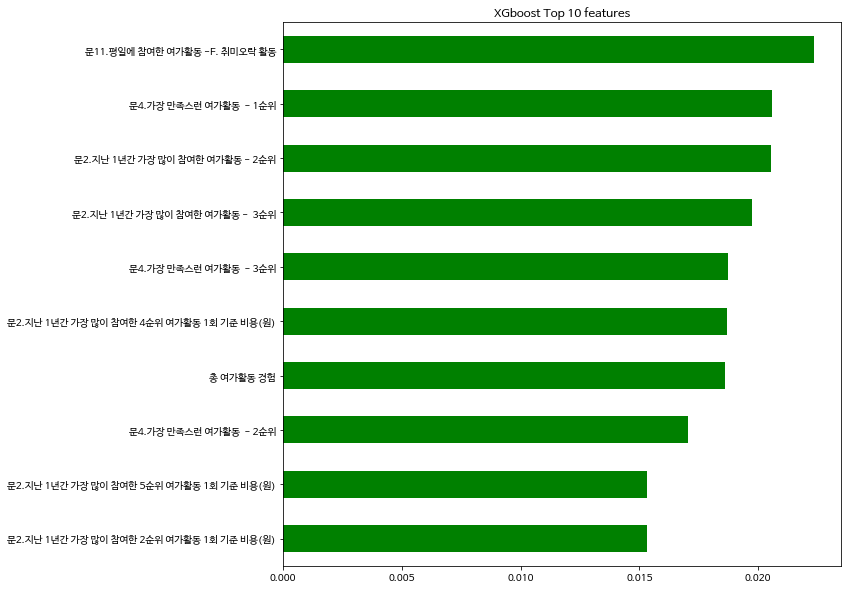

In [ ]:
xgbc_imp = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)[0:10]
n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'XGboost Top 10 features')
xgbc_imp.sort_values().plot.barh(color='g');

In [ ]:
0.1256 ± 0.0041	문36.만 나이
0.0814 ± 0.0079	문35.혼인상태
0.0379 ± 0.0008	문34.본인의 교육정도 - 최종학력
0.0262 ± 0.0037	문43.주당 평균 근무 시간
0.0189 ± 0.0025	문4.가장 만족스런 여가활동 - 1순위
0.0176 ± 0.0022	문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원)
0.0168 ± 0.0014	문2.지난 1년간 가장 많이 참여한 2순위 여가활동 1회 기준 비용(원)
0.0165 ± 0.0017	문4.가장 만족스런 여가활동 - 2순위
0.0139 ± 0.0010	문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원)
0.0133 ± 0.0014	문4.가장 만족스런 여가활동 - 3순위
0.0125 ± 0.0018	총 여가활동 경험
0.0125 ± 0.0017	문2.지난 1년간 가장 많이 참여한 여가활동 - 3순위
0.0123 ± 0.0024	문2.지난 1년간 가장 많이 참여한 여가활동 - 5순위
0.0121 ± 0.0011	문11.평일에 참여한 여가활동 -F. 취미오락 활동
0.0115 ± 0.0018	문2.지난 1년간 가장 많이 참여한 3순위 여가활동 1회 기준 비용(원)

In [ ]:
0.1624 ± 0.0048	문36.만 나이
0.1064 ± 0.0033	문35.혼인상태
0.0591 ± 0.0057	문34.본인의 교육정도 - 최종학력
0.0215 ± 0.0028	문43.주당 평균 근무 시간
0.0103 ± 0.0013	문4.가장 만족스런 여가활동 - 1순위
0.0098 ± 0.0013	문30.전반적 여가생활 만족도
0.0095 ± 0.0006	문2.지난 1년간 가장 많이 참여한 여가활동 - 5순위
0.0093 ± 0.0012	문4.가장 만족스런 여가활동 - 3순위
0.0092 ± 0.0014	문4.가장 만족스런 여가활동 - 2순위
0.0081 ± 0.0019	문2.지난 1년간 가장 많이 참여한 5순위 여가활동 1회 기준 비용(원)
0.0076 ± 0.0005	총 여가활동 경험
0.0076 ± 0.0015	문11.평일에 참여한 여가활동 -F. 취미오락 활동
0.0074 ± 0.0006	문2.지난 1년간 가장 많이 참여한 여가활동 - 4순위
0.0074 ± 0.0010	문2.지난 1년간 가장 많이 참여한 1순위 여가활동 동반자
0.0070 ± 0.0019	문2.지난 1년간 가장 많이 참여한 3순위 여가활동 1회 기준 비용(원)

In [ ]:
#두 모델 모두 상위 5개의 특성은 모두 동일했으며
  #그 외의 특성들도 비슷한 순서와 순위를 보였습니다.

#눈여겨 볼 점은 여가생활보다 응답자의 나이 혼인상태 교육정도등의 개인정보가가 여가활동 정보보다 예측에 더 중요하게 작용했다는 점입니다.

In [ ]:
#개인정보를 제외한 순수 여가정보로 가구소득을 측정해보겠습니다.
  #개인정보 특성을 제외하고나면 5-6% 정도의 정확도 하락이 있었습니다.

#여가 정보만으로 개인의 소득 수준을 구분짓는데에는 어느정도 한계가 있던것 같습니다. 이를 극복하려면 10000개남짓의 데이터에서 더 많은 수의 데이터가 필요할 것으로 보입니다.

* 그렇다면 몇몇 주요 특성들이 예측에 어떻게 영향을 주는지 더 자세하게 확인해 보도록 하겠습니다.

In [ ]:
X_test2['문화예술 관람']

460     1.0
1569    1.0
4532    1.0
6153    0.0
9266    1.0
       ... 
3910    1.0
7102    2.0
3635    2.0
2966    1.0
7061    2.0
Name: 문화예술 관람, Length: 2100, dtype: float64

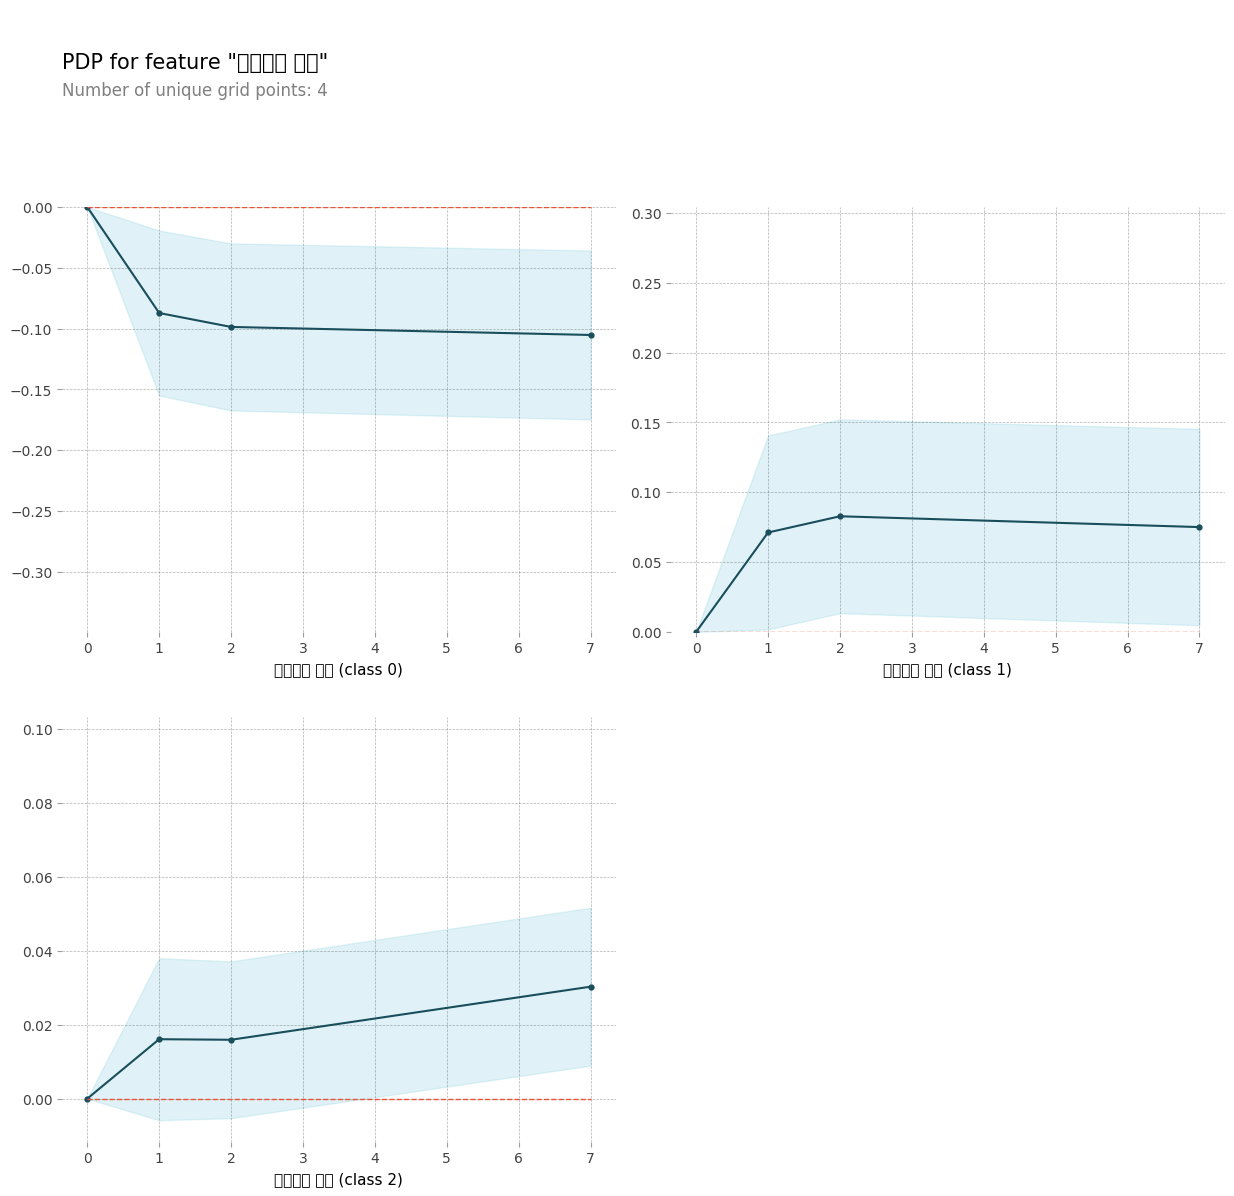

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = '문화예술 관람'

import matplotlib.pyplot as plt
from pdpbox import pdp
plt.rc('font', family='NanumBarunGothic') 
plt.rcParams['figure.dpi'] = 100
pdp_dist = pdp.pdp_isolate(model=forest, dataset=X_test2, model_features=X_test2.columns, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

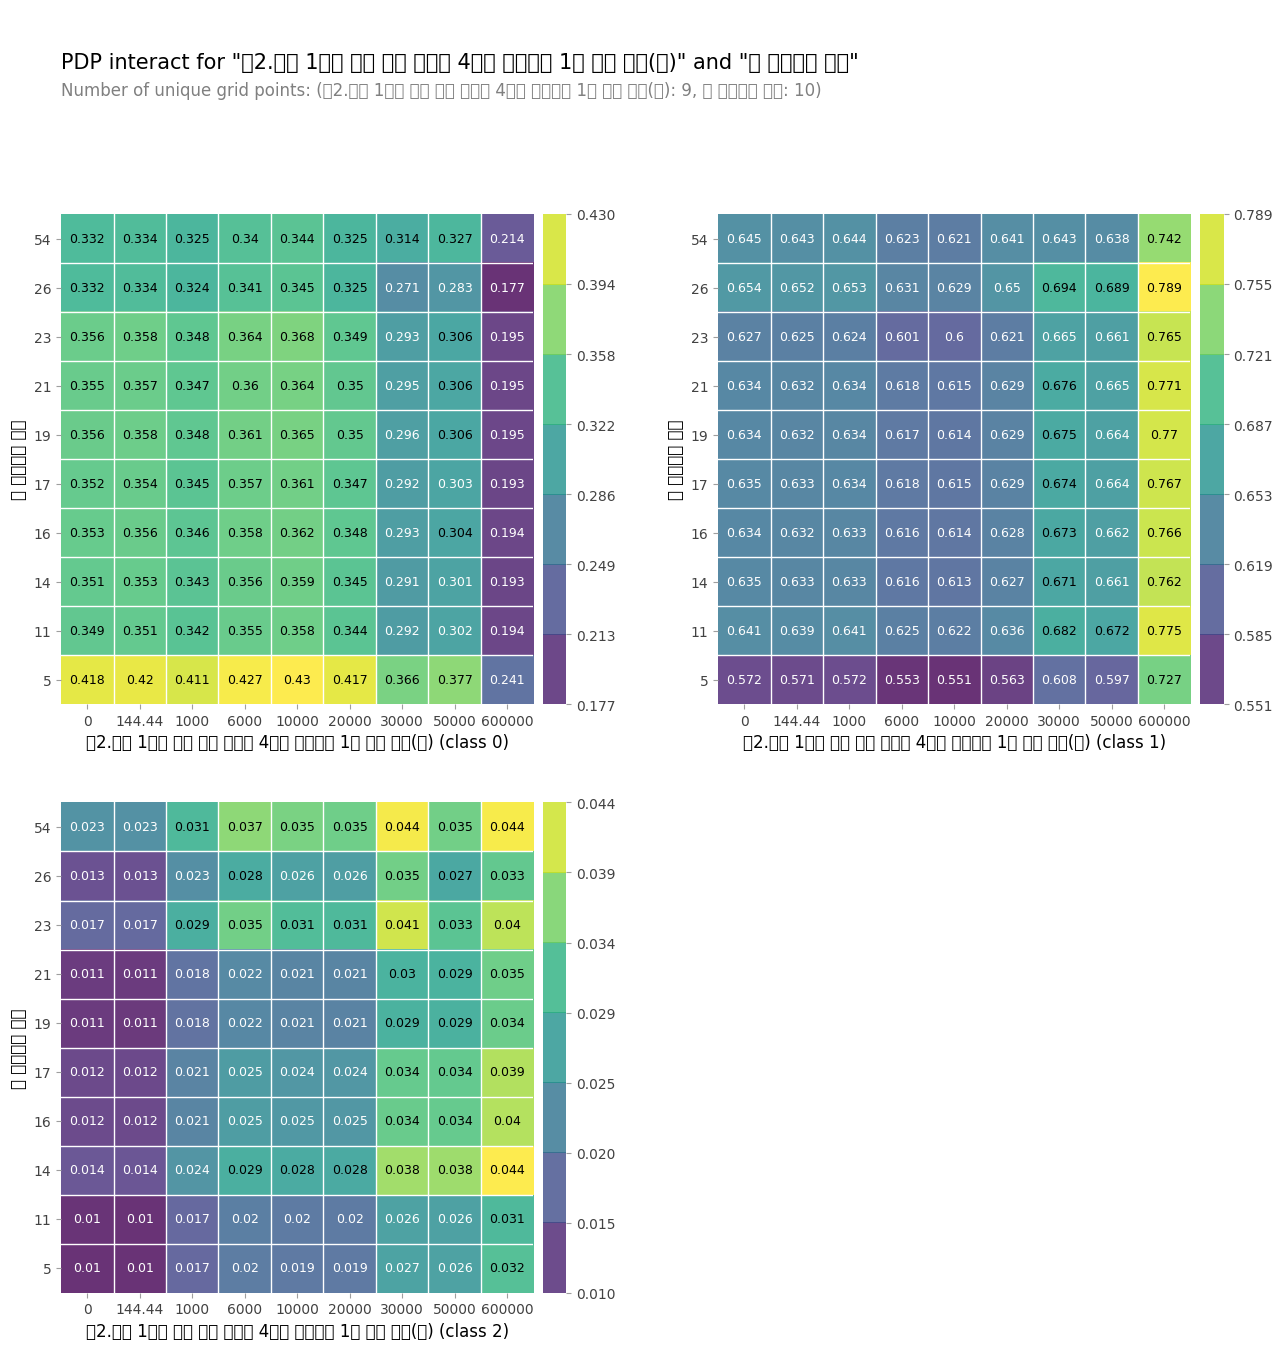

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot
# 2D PDP
features = ['문2.지난 1년간 가장 많이 참여한 4순위 여가활동 1회 기준 비용(원)', '총 여가활동 경험']

interaction = pdp_interact(
    model=xgbc, 
    dataset=X_test2, 
    model_features=X_test2.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);



> 각 클래스별 샘플을 확인해서 어떤 특성들이 어떤 방향으로 예측하게했는지 확안해 보겠습니다.



In [ ]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다
row = X_test2.iloc[[31]]
row
print(y_test2.iloc[[31]])
import shap
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

3741    1
Name: 문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구, dtype: int64


In [ ]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다
row = X_test2.iloc[[1]]
row
print(y_test2.iloc[[1]])
import shap
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[1], 
    shap_values=shap_values[1], 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

1569    2
Name: 문45.지난 1년 간 세금 공제 전 월 평균 소득- 가구, dtype: int64


In [ ]:
# 테스트셋에서 인덱스 1 샘플의 예측을 살펴보겠습니다.
# 우선 모든 특성 수치를 봅시다
row = X_test2.loc[[10414]]
row
print(y_test2.loc[10414])
import shap
explainer = shap.TreeExplainer(forest)
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[2], 
    shap_values=shap_values[2], 
    features=row, 
    link='logit' # SHAP value를 확률로 변환해 표시합니다.
)

3
